# Classification

For classification I use three models: logistic regression, a one-layer dense network, and a two-layer dense network. First the high-level features data is split in training, validation, and test data. At the end, I compare performance of the classification models for each model used for feature extraction.

## 1. Import packages, define class names, select model, and load features from file

In [1]:
import numpy as np
import os
import pandas as pd
import re
from sklearn.utils import class_weight 

In [2]:
class_names = ['adenosis',
            'ductal_carcinoma',
            'fibroadenoma',
            'lobular_carcinoma',
            'mucinous_carcinoma',
            'papillary_carcinoma',
            'phyllodes_tumor',
            'tubular_adenoma']

#### Choose one of the models

The user must select one of the models by setting the corresponding variable to `True`

In [3]:
isVGG16=False
isInceptionV3=False
isResNet50=False
isXception=False
isDenseNet121=False
isInceptionResNetV2=False
isEfficientNet0=True

#### Set high-level feature file name

In [4]:
if isVGG16==True:             ffilename = 'features_patches_VGG16.npz'
if isInceptionV3==True:       ffilename = 'features_patches_InceptionV3.npz'
if isResNet50==True:          ffilename = 'features_patches_ResNet50.npz'
if isXception==True:          ffilename = 'features_patches_Xception.npz'
if isDenseNet121==True:       ffilename = 'features_patches_DenseNet121.npz'
if isInceptionResNetV2==True: ffilename = 'features_patches_InceptionResNetV2.npz'
if isEfficientNet0==True:     ffilename = 'features_patches_EfficientNetB0.npz'

#### Get model's name as string

In [5]:
model_str = re.sub('.*_(.*)\.npz', '\\1', ffilename)
model_str

'EfficientNetB0'

#### Load features from file

In [6]:
with np.load(os.path.join('data', 'HLfeatures', ffilename)) as features_npz:
    features_dict = dict(features_npz)

nf = features_dict['arr_0'].shape[1] - 2
features = features_dict['arr_0'][:,:nf].astype(float)
labs = features_dict['arr_0'][:,nf].astype(int)
fns = features_dict['arr_0'][:,-1]
print('Shape of features:', features.shape, '\nShape of labs:', labs.shape, '\nShape of filenames:', fns.shape)

Shape of features: (7980, 1280) 
Shape of labs: (7980,) 
Shape of filenames: (7980,)


In [7]:
print('dtype of features:', features.dtype, '\ndtype of labels:  ', labs.dtype)

dtype of features: float64 
dtype of labels:   int64


## 2. Split features in train (80%), validation (10%), and test (10%) data

It is common to split data in 80% for training, 10% for validation, and another 10% for testing. I do this in two steps with `train_test_split()` function from `sklearn.model_selection` modul.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Split into train/rest sets
X_tr, X_, y_tr, y_, fn_tr, fn_ = train_test_split(
    features, labs, fns,
    test_size=0.2, random_state=0)

# Split rest into valid/test sets
X_val, X_te, y_val, y_te, fn_val, fn_te = train_test_split(
    X_, y_, fn_, 
    test_size=0.5, random_state=0)

print('train X:', X_tr.shape, '\n      y:', y_tr.shape)
print('valid X:', X_val.shape, '\n      y:', y_val.shape)
print('test  X:', X_te.shape, '\n      y:', y_te.shape)

train X: (6384, 1280) 
      y: (6384,)
valid X: (798, 1280) 
      y: (798,)
test  X: (798, 1280) 
      y: (798,)


#### Proportion of numbers per class

Get counts and proportions for train/valid/test set for each class

In [10]:
# define function to get counts and proportion
# y: vector of value labels (0..7)
def get_counts(y):
    labs_num = pd.DataFrame(y)[0]
    labs_num_prop = labs_num.value_counts(normalize=True).sort_index()
    labs_num_prop = np.round(labs_num_prop*100, 1)
    labs_num_count = labs_num.value_counts().sort_index()
    return(labs_num_count, labs_num_prop)

In [11]:
# compose table with counts and proportions
count_tr, prop_tr   = get_counts(y_tr)
count_val, prop_val = get_counts(y_val)
count_te, prop_te   = get_counts(y_te)

class_df = pd.DataFrame({'count train': count_tr, 'count validation': count_val, 'count test': count_te,
                         'proportion train (%)': prop_tr, 'proportion validation (%)': prop_val,'proportion test (%)': prop_te,})
class_df.index = class_names
count_total = class_df.iloc[:,0] + class_df.iloc[:,1] + class_df.iloc[:,2]
class_df['proportion train split (%)'] = np.round(class_df.iloc[:,0] / count_total * 100, 1)
class_df['proportion validation split (%)'] = np.round(class_df.iloc[:,1] / count_total * 100, 1)
class_df['proportion test split (%)'] = np.round(class_df.iloc[:,2] / count_total * 100, 1)
class_df

,count train,count validation,count test,proportion train (%),proportion validation (%),proportion test (%),proportion train split (%),proportion validation split (%),proportion test split (%)
adenosis,378,35,43,5.9,4.4,5.4,82.9,7.7,9.4
ductal_carcinoma,2790,334,332,43.7,41.9,41.6,80.7,9.7,9.6
fibroadenoma,808,105,99,12.7,13.2,12.4,79.8,10.4,9.8
lobular_carcinoma,505,62,57,7.9,7.8,7.1,80.9,9.9,9.1
mucinous_carcinoma,635,84,101,9.9,10.5,12.7,77.4,10.2,12.3
papillary_carcinoma,451,75,54,7.1,9.4,6.8,77.8,12.9,9.3
phyllodes_tumor,354,42,40,5.5,5.3,5.0,81.2,9.6,9.2
tubular_adenoma,463,61,72,7.3,7.6,9.0,77.7,10.2,12.1


One can see, that for each data set, i.e., for train, validation, and test set, each class has nearly the same proportion of features therein. One can also see, that split proportions (80% train, 10% validation, and 10% test) are preserved within classes.

#### Compute class weights

I will use class weights (inverse proportional to class counts) for classification, as classes are unbalanced.

In [12]:
# https://stackoverflow.com/a/67678520
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_tr), 
    y=y_tr)

train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 2.111111111111111,
 1: 0.2860215053763441,
 2: 0.9876237623762376,
 3: 1.5801980198019803,
 4: 1.2566929133858267,
 5: 1.76940133037694,
 6: 2.2542372881355934,
 7: 1.7235421166306695}

## 3. Logistic regression

Logistic regression serves as a kind of baseline model, as it is very fast and works out-of-the-box.

#### Import packages

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#### Create the estimator

I use here a pipeline to make sure, that data is standardaize before computing logistic regression.

In [14]:
logreg = make_pipeline(
    StandardScaler(), 
    LogisticRegression(solver='liblinear',  multi_class='auto', class_weight=train_class_weights)
)

#### Fit it to train data

In [15]:
logreg.fit(X_tr, y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight={0: 2.111111111111111,
                                                  1: 0.2860215053763441,
                                                  2: 0.9876237623762376,
                                                  3: 1.5801980198019803,
                                                  4: 1.2566929133858267,
                                                  5: 1.76940133037694,
                                                  6: 2.2542372881355934,
                                                  7: 1.7235421166306695},
                                    solver='liblinear'))])

#### Accuracy on test set

In [16]:
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.788


#### Save result to file

In [17]:
df = pd.DataFrame({
    'HLfeatures model': model_str,
    'model': 'logistic regression', 
    'test_accuracy': np.round(accuracy, 3)}, index=[0])
#df.to_csv('testacc.txt', mode='a', header=False)

## 4. One-layer dense network

#### Import functions from modul `keras`

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import EarlyStopping

#### Define sequential model

Here a basic sequential model is created with one dense layer (8 output neurons, and softmax activation). Number of parameters is $n_{features}\cdot 8+8$

In [19]:
model = Sequential()
model.add(InputLayer(input_shape=(nf,)))
model.add(Dense(8, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 10248     
Total params: 10,248
Trainable params: 10,248
Non-trainable params: 0
_________________________________________________________________


2022-03-17 08:57:34.456689: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Define loss function, optimizer, and metrics to track during training

In [20]:
model.compile(
    optimizer='sgd',  # Gradient descent (with momentum) optimizer
    loss='sparse_categorical_crossentropy',  # labels are encoded as 0,1,2,... 
    metrics=['acc']  # track accuracy during training
)

#### End training when accuracy stops improving (optional)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

#### Fit model

In [22]:
#train_class_weights = {str(k):v for k,v in train_class_weights.items()}
#train_class_weights

In [23]:
history = model.fit(
    x=X_tr, y=y_tr,
    validation_data=(X_val, y_val), 
    batch_size=32, 
    epochs=200,
    shuffle=True, # Shuffle training samples
    callbacks=[early_stopping],
    class_weight=train_class_weights,
)

2022-03-17 08:57:34.631384: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
200/200 [==============================] - 1s 3ms/step - loss: 1.8033 - acc: 0.3084 - val_loss: 1.6498 - val_acc: 0.4248
Epoch 2/200
200/200 [==============================] - 0s 1ms/step - loss: 1.4805 - acc: 0.4574 - val_loss: 1.4770 - val_acc: 0.4674
Epoch 3/200
200/200 [==============================] - 0s 1ms/step - loss: 1.3404 - acc: 0.4970 - val_loss: 1.3842 - val_acc: 0.4862
Epoch 4/200
200/200 [==============================] - 0s 1ms/step - loss: 1.2502 - acc: 0.5262 - val_loss: 1.3021 - val_acc: 0.5288
Epoch 5/200
200/200 [==============================] - 0s 1ms/step - loss: 1.1856 - acc: 0.5403 - val_loss: 1.2439 - val_acc: 0.5514
Epoch 6/200
200/200 [==============================] - 0s 1ms/step - loss: 1.1356 - acc: 0.5580 - val_loss: 1.1857 - val_acc: 0.5652
Epoch 7/200
200/200 [==============================] - 0s 2ms/step - loss: 1.0950 - acc: 0.5744 - val_loss: 1.1952 - val_acc: 0.5702
Epoch 8/200
200/200 [==============================] - 0s 1ms/step - 

#### Plot loss and accuracy values

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_acc(history, fig, axs):
    # Plot accuracy values
    ax1.plot(history.history['loss'], label='train loss')
    ax1.plot(history.history['val_loss'], label='val loss')
    ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
        np.mean(history.history['val_loss'][-3:]) # last three values
    ))
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss value')
    ax1.legend()

    # Plot accuracy values
    ax2.plot(history.history['acc'], label='train acc')
    ax2.plot(history.history['val_acc'], label='val acc')
    ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
        np.mean(history.history['val_acc'][-3:]) # last three values
    ))
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    plt.show()

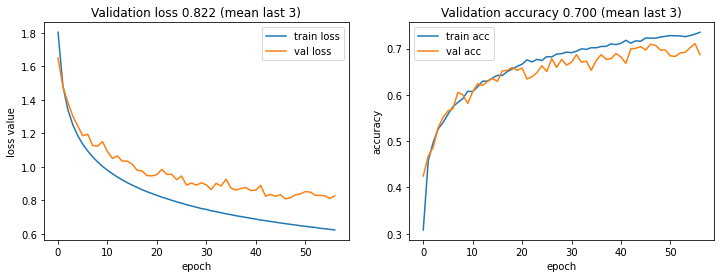

In [25]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_acc(history, fig, (ax1, ax2))

Model learns very well, as both lines go nearly hand in hand, from epoch to epoch. Overfitting seems also not to be the case, as lines have not reached plateau.

## 5. Two-layer dense network

#### Define sequential model

Here a model with one more dense layer (32 neurons, reLU (Rectified Linear Unit) activation) is defined.

In [26]:
model2 = Sequential()
model2.add(Dense(32, activation='relu', input_dim=nf))
model2.add(Dense(8, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 41,256
Trainable params: 41,256
Non-trainable params: 0
_________________________________________________________________


#### Define loss function, optimizer, and metrics to track during training

In [27]:
model2.compile(
    optimizer='sgd',  # Gradient descent (with momentum) optimizer
    loss='sparse_categorical_crossentropy',  # labels are encoded as 0,1,2,... 
    metrics=['acc']  # track accuracy during training
)

#### End training when accuracy stops improving (optional)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

#### Fit model

In [29]:
history2 = model2.fit(
    x=X_tr, y=y_tr,
    validation_data=(X_val, y_val), 
    batch_size=32, 
    epochs=200,
    shuffle=True, # Shuffle training samples
    callbacks=[early_stopping]
)

Epoch 1/200
200/200 [==============================] - 1s 2ms/step - loss: 1.6178 - acc: 0.4572 - val_loss: 1.5210 - val_acc: 0.4461
Epoch 2/200
200/200 [==============================] - 0s 1ms/step - loss: 1.3903 - acc: 0.5247 - val_loss: 1.3269 - val_acc: 0.5276
Epoch 3/200
200/200 [==============================] - 0s 1ms/step - loss: 1.2396 - acc: 0.5672 - val_loss: 1.1953 - val_acc: 0.5727
Epoch 4/200
200/200 [==============================] - 0s 1ms/step - loss: 1.1319 - acc: 0.6049 - val_loss: 1.1147 - val_acc: 0.6078
Epoch 5/200
200/200 [==============================] - 0s 1ms/step - loss: 1.0549 - acc: 0.6305 - val_loss: 1.0462 - val_acc: 0.6253
Epoch 6/200
200/200 [==============================] - 0s 1ms/step - loss: 0.9992 - acc: 0.6482 - val_loss: 0.9985 - val_acc: 0.6353
Epoch 7/200
200/200 [==============================] - 0s 1ms/step - loss: 0.9519 - acc: 0.6623 - val_loss: 0.9613 - val_acc: 0.6516
Epoch 8/200
200/200 [==============================] - 0s 1ms/step - 

#### Plot loss and accuracy values

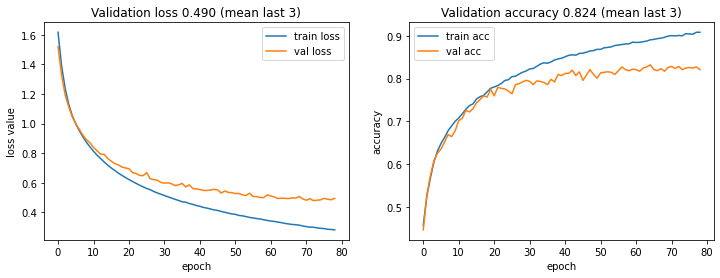

In [30]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_acc(history2, fig, (ax1, ax2))

Model learns very well, as both lines go nearly hand in hand, from epoch to epoch. Overfitting seems to start at epoch 50, as validation accuracy reaches plateau.

## 6. Evaluate models on test data

#### Evaluate one-layer dense network

In [31]:

loss, accuracy = model.evaluate(X_te, y_te, verbose=0)

print('Test accuracy 1-layer model: {:.3f}'.format(accuracy))

# save result to file
df = pd.DataFrame({
    'HLfeatures model': model_str,
    'model': '1-layer nn', 
    'test_accuracy': np.round(accuracy,3)}, index=[0])
#df.to_csv('testacc.txt', mode='a', header=False)

Test accuracy 1-layer model: 0.689


#### Evaluate two-layer dense network

In [32]:
# evaluate the model
loss, accuracy, = model2.evaluate(X_te, y_te, verbose=0)

print('Test accuracy 2-layer model: {:.3f}'.format(accuracy))

# save result to file
df = pd.DataFrame({
    'HLfeatures model': model_str,
    'model': '2-layer nn', 
    'test_accuracy': np.round(accuracy,3)}, index=[0])
#df.to_csv('testacc.txt', mode='a', header=False)

Test accuracy 2-layer model: 0.794
